# Imports

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pk
from collections import defaultdict
import re

from sentence_transformers import SentenceTransformer
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

# get stopwords
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.update(["use", "using",  "brick", "brick-", "bricks", "paperclip", "paperclip-", "paperclips", "n't", "like", "someone", "something", "like", "things", "diy", "DIY", "also", "along", "another"])   # additional words to remove from the responses

import warnings
warnings.simplefilter(action='ignore')

[nltk_data] Downloading package punkt to /Users/snath/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/snath/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Functions

In [40]:
def remove_stopwords(sentence):
    """Remove stopwords in sentence
    Args:
        sentence (str): text to remove stopwords
    Returns:
        cleaned text
    """
    word_tokens = word_tokenize(sentence)                                                       # Tokenize the sentence
    filtered_sentence = [word for word in word_tokens if word.lower() not in stop_words]        # Remove stopwords
    response = ' '.join(filtered_sentence)                                                      # Join words back into a string
    response = re.sub(r'\s*\([^)]*\)|\s*\([^)]*$', '', response)                                # remove '()' and anything in it
    return response

def get_sentence_transformer_embeddings(texts):
    """Extracts Text Embeddings using SentenceTransformer (model: gte-large)
    Args:
        texts (list): List of texts
    Returns:
        dict: Text and corresponding embedding
    """
    model = SentenceTransformer('thenlper/gte-large')
    embeddings = model.encode(texts)
    embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)         # normalise embeddings
    return dict(zip(texts, embeddings))

def get_clusters(embeddings, texts, cluster_assignment, printclusters):
    """Helper function for perform_hierarchicalClustering()
    Args:
        embeddings (list): List of embeddings
        texts (list): List of texts
        cluster_assignment (list): cluster assignment for each text/embedding
        printcluster (bool): True will print all texts in each cluster
    Returns:
        response_to_cluster dict: text to cluster number
        cluster_to_response dict: cluster number to list of texts in that cluster
        num_clusters int: number of clusters
        min_similarities dict: cluster to min text similiarity
    """

    cluster_to_response = defaultdict(list)                                 # make cluster_to_response
    cluster_to_embeddings = defaultdict(list)                               # make cluster_to_embeddings (used for min sim)
    for ind, cluster_num in enumerate(cluster_assignment):
        cluster_to_response[cluster_num].append(texts[ind])
        cluster_to_embeddings[cluster_num].append(embeddings[ind])
    
    response_to_cluster = dict(zip(texts, cluster_assignment))              # make response_to_cluster 
    
    num_clusters = len(np.unique(cluster_assignment))                       # find num clusters

    min_similarities = {}                                                   # find min paiwise text similarity in each cluster
    for cl in cluster_to_embeddings:
        stacked = np.array(cluster_to_embeddings[cl])
        sim = stacked @ stacked.T
        np.fill_diagonal(sim, np.inf)
        min_sim = np.min(sim)
        min_similarities[cl] = min_sim
    
    if printclusters:                                                       # print clusters if True
        for cluster_num, responses in cluster_to_response.items():
            print(f"Cluster {cluster_num}")
            print(responses, end="\n\n")

    return response_to_cluster, cluster_to_response, num_clusters, min_similarities

def perform_hierarchicalClustering(embeddings, texts, ax, cut_off_distance, printclusters):
    """Performs hierarchical clustering
    Args:
        embeddings (list): List of embeddings
        texts (list): List of texts
        ax: axes for plotting
        cut_off_distance (float): distance threshold for hierarchical clustering
        printcluster (bool): True will print all texts in each cluster
    Calls:
        get_clusters()
    """
    linked = linkage(embeddings, 'ward')                                                                                                    # 'ward' distance for measuring distance between clusters
    dendrogram(linked, orientation='top', labels=texts, distance_sort='descending', show_leaf_counts=False, no_labels=True, ax=ax[0])       # Make dendogram
    
    # Elbow plot -- Plot mean minsim/number of clusters as a fn of cut-off distance
    mean_minsemsim = []
    num_clusters = []
    for cod in np.linspace(1, 8, 30):
        cluster_assignment = fcluster(linked, t=cod, criterion='distance')
        _, _, _, minsims = get_clusters(embeddings, texts, cluster_assignment, False)
        mean_minsemsim.append(np.mean(list(minsims.values())))
        num_clusters.append(len(np.unique(cluster_assignment)))
    ax[1].plot(np.linspace(1, 8, 30), mean_minsemsim)
    ax[1].set_xlabel("Cut-off distance"); ax[1].set_ylabel("Mean cluster semantic similarity")
    ax[2].plot(np.linspace(1, 8, 30), num_clusters)
    ax[2].set_xlabel("Cut-off distance"); ax[2].set_ylabel("Number of clusters")

    cluster_assignment = fcluster(linked, t=cut_off_distance, criterion='distance')         # assign clusters using the decided cut_off_distance
    return get_clusters(embeddings, texts, cluster_assignment, printclusters)

def calculate_cosine_similarity(embedding1, embedding2):
    """Calculates cosine similarity between two embeddings
    Args:
        embedding1: first embedding
        embedding2: second embedding
    Returns:
        cosine similarity
    """
    if np.any(embedding1) and np.any(embedding2):
        return np.dot(embedding1, embedding2)
    else:
        return 0

## Load and Filter Files

In [41]:
def load_and_filter_files_humans():
    aut = pd.read_csv("../data/210318_AUTPROCESS_aut-response.csv")    # load AUT brick file -- 258 ppts
    vf = pd.read_csv("../data/210318_AUTPROCESS_vf-response.csv")      # load AUT paperclip file -- 251 ppts

    aut = aut.drop(["AUT-response_id", "toptwo"], axis = 1)            # drop columns
    vf = vf.drop(["VF-response_id"], axis = 1)

    aut.loc[aut["stimulus_fk"] == 1, "stimulus_fk"] = 2                 # encode AUT brick as 2, AUT paperclip as 3, VF as 1

    data = pd.concat([aut, vf], axis=0, ignore_index=True)              # concat files
    data = data.rename(columns = {"participant_fk" : "pid", "stimulus_fk" : "task", "response": "original_response_Dutch"})         # rename columns    
    data = data.sort_values(by=['pid', 'task', 'starttime'])            # sort by pid, task and starttime

    # Remove people who gave many responses with commas
    pids_to_remove = data[data['original_response_Dutch'].str.count(',') > 2]["pid"].unique()
    data = data[~data["pid"].isin(pids_to_remove)]

    # Only keep ppts in all 3 tasks:
    pid_in_all_tasks = set.intersection(*(set(data[data['task'] == task]['pid']) for task in data['task'].unique()))
    data = data[data['pid'].isin(pid_in_all_tasks)]

    return data

def load_and_filter_files_LLMs():
    data_autbrick = pd.read_csv("../data_LLM/results_task2_final_foranalysis.csv")      # load AUT brick file
    data_autpaperclip = pd.read_csv("../data_LLM/results_task3_final_foranalysis.csv")  # load AUT paperclip file
    data_vf = pd.read_csv("../data_LLM/results_task1_final_foranalysis.csv")            # load VF file
    data = pd.concat([data_vf, data_autbrick, data_autpaperclip], ignore_index=True)    # concat files
    data = data.rename(columns = {"cleaned_responses" : "original_response"})           # rename/drop columns
    data = data.drop(columns=["Unnamed: 0"])
    data.loc[data["task"] == "brick", "task"] = 2                                       # encode task as 2,3,1: 2: AUT brick, 3: AUT paperclip, 1: VF
    data.loc[data["task"] == "paperclip", "task"] = 3
    data.loc[data["task"] == "animals", "task"] = 1
    return data

data_humans = load_and_filter_files_humans()        # get human data
data_LLMs = load_and_filter_files_LLMs()            # get LLM data

## Write columns

In [42]:
num_resp = 18                                       # number of responses to analyse

In [43]:
def write_columns_humans(data):
    data["original_response"] = data["original_response_Dutch"].map(pk.load(open("../translations/response_Dutch_to_response_English.pk", "rb")))   # get translations
    data.loc[pd.isna(data['original_response']), "original_response"] = data[pd.isna(data['original_response'])]["original_response_Dutch"]         # if original_response is None, just set it to original_response_Dutch (there is one such instance where response is '[]')
    data["original_response_cleaned"] = data['original_response'].apply(remove_stopwords)                   # remove stopwords
    data['original_response_cleaned'] = data['original_response_cleaned'].str.replace('[^\w\s]','')         # remove punctuation
    data = data[data["original_response_cleaned"] != ""]                                                    # remove responses which are empty after cleaning, for example "brick"

    # get cleaned/corrected responses, invalid, jump ground truth (for AUT brick) and merge to get final "response"
    # AUT brick
    data_cleaned_autbrick = pd.read_csv("../csvs/data_humans_autbrick_cleaned.csv")                         
    data_cleaned_autbrick = data_cleaned_autbrick.rename(columns = {"response" : "original_response_Dutch", "response_English" : "original_response", "response_English_cleaned": "original_response_cleaned", "response_English_corrected": "response"}) #"response_English_corrected" is now "response"
    data = pd.merge(data, data_cleaned_autbrick[["pid", "task", "starttime", "endtime", "original_response_Dutch", "original_response", "response", "invalid", "jump_GT"]], on=["pid", "task", "starttime", "endtime", "original_response_Dutch", "original_response"], how="left")
    
    # AUT paperclip
    data_cleaned_autpaperclip = pd.read_csv("../csvs/data_humans_autpaperclip_cleaned.csv")
    data = pd.merge(data, data_cleaned_autpaperclip[["pid", "task", "starttime", "endtime", "original_response_Dutch", "original_response", "response_corrected", "invalid"]], on=["pid", "task", "starttime", "endtime", "original_response_Dutch", "original_response"], how="left", suffixes=('', '_cleaned'))
    data.loc[~pd.isnull(data["response_corrected"]), "response"] = data["response_corrected"]
    data.loc[data["invalid_cleaned"] == 1, "invalid"] = 1
    data.drop(columns=["response_corrected", "invalid_cleaned"], inplace=True)

    # VF
    data_cleaned_vf = pd.read_csv("../csvs/data_humans_vf_cleaned.csv")
    data = pd.merge(data, data_cleaned_vf[["pid", "task", "starttime", "endtime", "original_response_Dutch", "original_response", "response_corrected", "invalid"]], on=["pid", "task", "starttime", "endtime", "original_response_Dutch", "original_response"], how="left", suffixes=('', '_cleaned'))
    data.loc[~pd.isnull(data["response_corrected"]), "response"] = data["response_corrected"]
    data.loc[data["invalid_cleaned"] == 1, "invalid"] = 1
    data.drop(columns=["response_corrected", "invalid_cleaned"], inplace=True)

    data.loc[pd.isnull(data["response"]), "response"] = data["original_response_cleaned"]    # if response is null, just use the cleaned original response (with stopwords and punctuation removed)    
    data.loc[pd.isnull(data["invalid"]), "invalid"] = 0                                      # default invalid = False or 0
    data.loc[pd.isnull(data["jump_GT"]), "jump_GT"] = 1.0                                    # default jump ground truth = 1 or jump
    
    data = write_columns_common(data, "humans")
    data["RT"] = (data["endtime"] - data["starttime"])/1000

    return data

def write_columns_LLMs(data):
    data["pid"] = pd.factorize(data[['model', 'temp', 'rep']].apply(tuple, axis=1))[0] + 1   # Pid for LLM is model x temp x rep count. Adding 1 to start group numbering at 1
    data["original_response_cleaned"] = data['original_response'].apply(remove_stopwords)               # remove stopwords
    data['original_response_cleaned'] = data['original_response_cleaned'].str.replace('[^\w\s]','')     # remove punctuation
    data = data[data["original_response_cleaned"] != ""]                                                # remove responses which are empty after cleaning, for example "brick"

    # set "response" = cleaned original response (with stopwords and punctuation removed)
    data["response"] = data["original_response_cleaned"]
    data["invalid"] = np.NaN                            # invalid and jump_GT are NaN for LLMs
    data["jump_GT"] = np.NaN

    data = write_columns_common(data, "LLMs")
    data = data[~data["model"].isin(["snorkelai/Snorkel-Mistral-PairRM-DPO"])]      # ignore the Snorkel model for analysis
    
    return data

def write_columns_common(data, type):
    data = data[~(data["invalid"] == 1)]                                    # remove invalid rows
    data["response"] = data["response"].str.lower()                         # convert responses to lowercase
    data["response_len"] = data["response"].str.len()                       # write response length
    data["response_num_words"] = data['response'].str.split().str.len()     # write number of words per response
    data['previous_original_response'] = data['original_response'].shift(1) # write previous responses
    data['previous_response'] = data['response'].shift(1)
    data = data[data["response"] != data["previous_response"]]              # remove consecutive verbatim repeats

    if type == "humans":
        data["order"] = np.concatenate([np.arange(i) for i in data.groupby(["pid", "task"]).count()["response"].tolist()])    # order variable per ppt x task. Starts from 0
    elif type == "LLMs":
        data["order"] = np.concatenate([np.arange(i) for i in data.groupby(["task", "pid"]).count()["response"].tolist()])    # order variable per ppt x task. Starts from 0
    
    data.loc[data["order"] == 0, "previous_original_response"] = None       # previous response for order 0 should be None
    data.loc[data["order"] == 0, "previous_response"] = None
    data = data[data["order"] <= num_resp + 1]                              # only keep data upto num_resp + 1

    return data

data_humans = write_columns_humans(data_humans)     # write columns for human data
data_LLMs = write_columns_LLMs(data_LLMs)           # write columns for LLM data

In [44]:
print("For Humans:")
print("AUT Brick length =", len(data_humans[data_humans["task"] == 2].groupby("pid")))
print("AUT Paperclip length =" ,len(data_humans[data_humans["task"] == 3].groupby("pid")))
print("Verbal Fluency length =", len(data_humans[data_humans["task"] == 1].groupby("pid")))

print("For LLMs:")
print("AUT Brick length =", len(data_LLMs[data_LLMs["task"] == 2].groupby("pid")))
print("AUT Paperclip length =", len(data_LLMs[data_LLMs["task"] == 3].groupby("pid")))
print("Verbal Fluency length =", len(data_LLMs[data_LLMs["task"] == 1].groupby("pid")))

For Humans:
AUT Brick length = 220
AUT Paperclip length = 220
Verbal Fluency length = 220
For LLMs:
AUT Brick length = 440
AUT Paperclip length = 440
Verbal Fluency length = 440


## Get Embeddings

In [45]:
# AUT brick
texts_autbrick = list(set(data_humans[data_humans["task"] == 2]["response"].unique().tolist() + data_LLMs[data_LLMs["task"] == 2]["response"].unique().tolist()))       # humans + LLMs merged
texts_autbrick_humans = data_humans[data_humans["task"] == 2]["response"].unique().tolist()                                                                             # only humans
texts_autbrick_LLMs = data_LLMs[data_LLMs["task"] == 2]["response"].unique().tolist()                                                                                   # only LLMs

# AUT paperclip
texts_autpaperclip = list(set(data_humans[data_humans["task"] == 3]["response"].unique().tolist() + data_LLMs[data_LLMs["task"] == 3]["response"].unique().tolist()))   # humans + LLMs merged
texts_autpaperclip_humans = data_humans[data_humans["task"] == 3]["response"].unique().tolist()                                                                         # only humans
texts_autpaperclip_LLMs = data_LLMs[data_LLMs["task"] == 3]["response"].unique().tolist()                                                                               # only LLMs

# VF
texts_vf = list(set(data_humans[data_humans["task"] == 1]["response"].unique().tolist() + data_LLMs[data_LLMs["task"] == 1]["response"].unique().tolist()))             # humans + LLMs merged
texts_vf_humans = data_humans[data_humans["task"] == 1]["response"].unique().tolist()                                                                                   # only humans
texts_vf_LLMs = data_LLMs[data_LLMs["task"] == 1]["response"].unique().tolist()                                                                                         # only LLMs

In [46]:
# Embeddings saved in ./embeddings/. Takes ~4min on my machine to re-avaluate

filename = "sentence_transformer_embeddings_autbrick_gtelarge"
try:
    sentence_transformer_embeddings_autbrick = pk.load(open(f"../embeddings/{filename}.pk", "rb"))
except:
    sentence_transformer_embeddings_autbrick = get_sentence_transformer_embeddings(texts_autbrick)
    pk.dump(sentence_transformer_embeddings_autbrick, open(f"../embeddings/{filename}.pk", "wb")) 

filename = "sentence_transformer_embeddings_autpaperclip_gtelarge"
try:
    sentence_transformer_embeddings_autpaperclip = pk.load(open(f"../embeddings/{filename}.pk", "rb"))
except:
    sentence_transformer_embeddings_autpaperclip = get_sentence_transformer_embeddings(texts_autpaperclip)
    pk.dump(sentence_transformer_embeddings_autpaperclip, open(f"../embeddings/{filename}.pk", "wb"))

filename = "sentence_transformer_embeddings_vf_gtelarge"
try:
    sentence_transformer_embeddings_vf = pk.load(open(f"../embeddings/{filename}.pk", "rb"))
except:
    sentence_transformer_embeddings_vf = get_sentence_transformer_embeddings(texts_vf)
    pk.dump(sentence_transformer_embeddings_vf, open(f"../embeddings/{filename}.pk", "wb"))

## Response Categorization using Hierarchical Clustering

In [47]:
printclusters = True

### AUT Brick

Cluster 2
['sharpening knives', 'shovel', 'reinforce soil', 'crush into gravel', 'sandpiper shelter', 'strap as shoe', 'gravel', 'detergent', 'screwdriver', 'grinding', 'beveled edge', 'press', 'sandcastle', 'foot scrubber', 'well', 'shoe', 'tie feet to make stilts', 'mortar pestle', 'scrubbing tool', 'grinding herbs', 'printing press', 'sand paper', 'dig', 'spatula', 'stone', 'boot scraper', 'break into stones', 'skin scrub ', 'flats', 'primitive mortar pestle', 'tie shoes game', 'scrape', 'flatten book', 'knife sharpener', 'flatten cookie batter', 'sink in water', 'pressing tofu cheese', 'drown ', 'make edge', 'file nails', 'pool tool', 'spoon', 'press meat', 'flattener', 'grater', 'smash into stones', 'tie to make shoes', 'make sand', 'scratch bark', 'make ground firmer', 'ground', 'shoe sole', 'sharpen', 'sponge', 'fill in hole in wall', 'toothbrush', 'wiping feet', 'shoes', 'fill in hole', 'shovel to dig', 'tie feet', 'tools', 'swimming weight, sink in water', 'toothbrush holder',

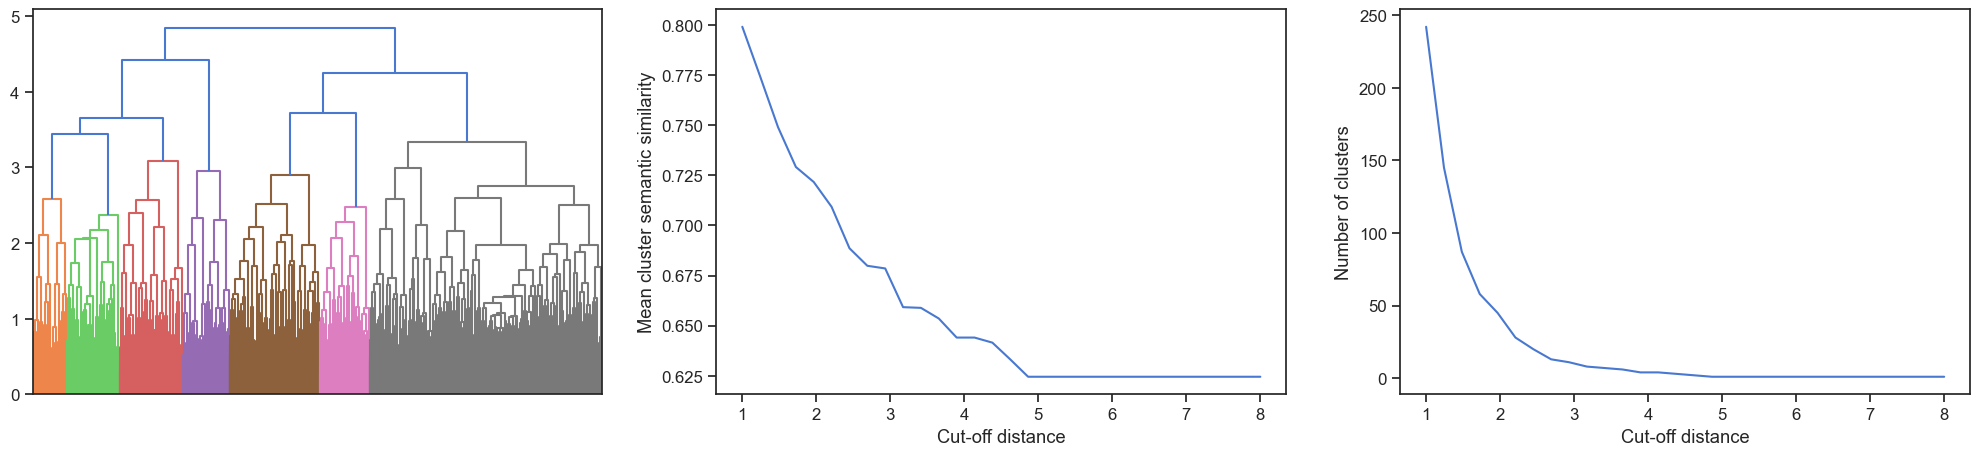

In [48]:
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
response_to_cluster_autbrick, cluster_to_response_autbrick, num_clusters_autbrick, minsim_autbrick = perform_hierarchicalClustering([sentence_transformer_embeddings_autbrick[x] for x in texts_autbrick], texts_autbrick, ax, 2.22, printclusters)
print("Num clusters =", num_clusters_autbrick)
print(np.min(list(minsim_autbrick.values())), np.mean(list(minsim_autbrick.values())))

### AUT Paperclip

Cluster 14
['remove string sweater', 'perfect makeup lines', 'hurt', 'boat anchor', 'spit', 'catapult', 'dollhouse furniture', 'lego figures clothing', 'experiment creativity', 'create puzzle', 'prevent pidgeons from entering balcony', 'stress helper', 'twist', 'school', 'could fold way looks thing bong put weed', 'dart flight', 'miniature weapon', 'recordkeeper', 'really ca think anything', 'compass', 'trail', 'hand clock', 'printer', 'squeezing pimple', 'puncture football', 'escape prison', 'board game token', 'pierce finger for blood', 'clip lip', 'make ring niece nephew', 'participate trading game', 'collect', 'collecting', 'pointing stick', 'special baseball', 'put fingers', 'science experiment', 'stirrup', 'confirmation ivy', 'ring', 'miniature tools', 'bike spoke reflector', 'slip', 'historical artifact', 'party favor', 'puzzlesolving', 'drinking game', 'creating trap', 'ankle band', 'poke eye', 'unfold craft thread', 'play game', 'thin', 'throw others', 'keep certificate recove

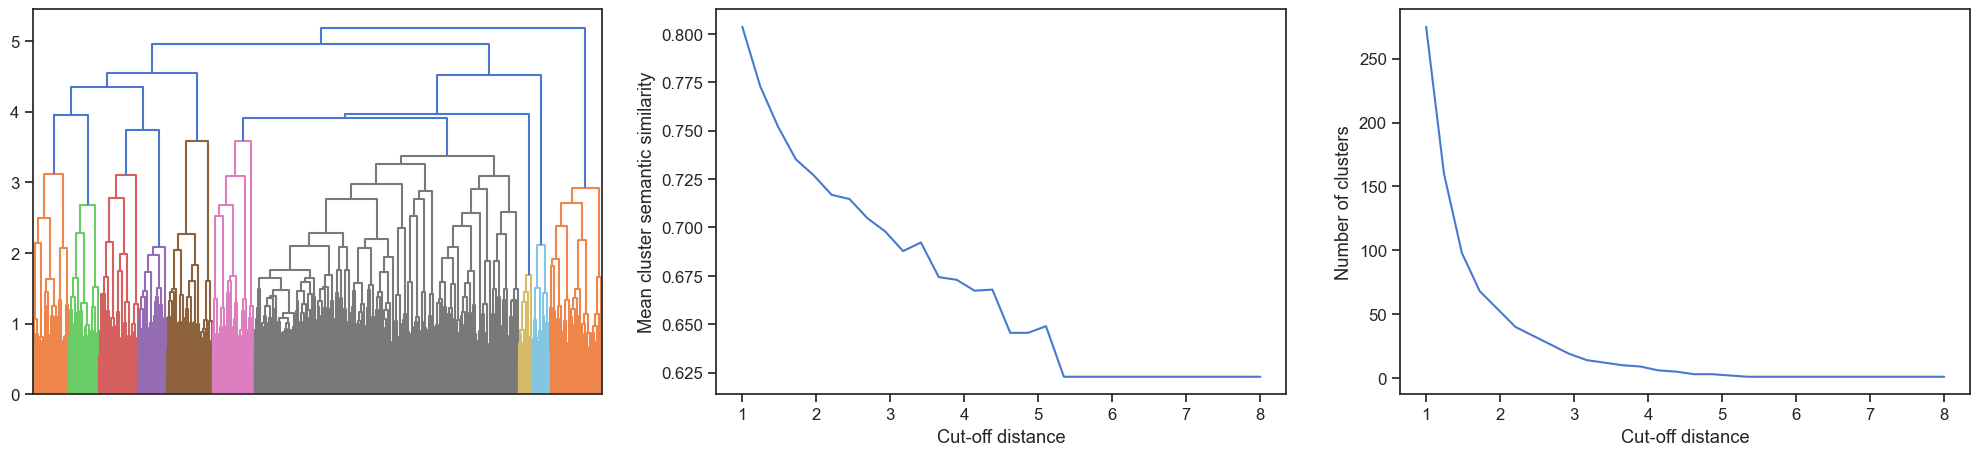

In [49]:
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
response_to_cluster_autpaperclip, cluster_to_response_autpaperclip, num_clusters_autpaperclip, minsim_autpaperclip = perform_hierarchicalClustering([sentence_transformer_embeddings_autpaperclip[x] for x in texts_autpaperclip], texts_autpaperclip, ax, 2.6, printclusters)
print("Num clusters =", num_clusters_autpaperclip)
print(np.min(list(minsim_autpaperclip.values())), np.mean(list(minsim_autpaperclip.values())))

### Verbal Fluency

Cluster 10
['owl', 'heron', 'crow', 'swan', 'seagull', 'budgie', 'quail', 'crane', 'dove', 'rooster', 'pheasant', 'bird', 'spoonbill', 'jay', 'marabou stork', 'macaw', 'goose', 'ostrich', 'robin', 'raven', 'hummingbird', 'canary', 'parrot', 'ladybird', 'eagle', 'cockatiel', 'coal tit', 'ibis', 'stork', 'weasel', 'ladybug', 'lorikeet', 'birds prey', 'blackbird', 'peacock', 'secretary bird', 'chicken', 'chough', 'chitterling', 'finch', 'birds', 'blue tit', 'duck', 'falcon', 'tit', 'lovebird', 'parakeet', 'elephantbird', 'woodpecker', 'sparrow', 'pigeon', 'starling', 'chitterlings', 'hawk', 'pelican', 'great tit', 'albatross', 'magpie', 'gadfly']

Cluster 8
['wolf', 'otter', 'beaver', 'elk', 'ford', 'buck', 'caribou', 'badger', 'wolverine', 'reindeer', 'black panther', 'foxcub', 'arctic fox', 'coyote', 'black widow', 'jaguar', 'wolforneyox', 'vulture', 'fox', 'skunk', 'deer', 'jaguarundi', 'moose', 'water buck']

Cluster 1
['snow leopard', 'bobcat', 'cats', 'cat', 'sand cat', 'leopard', '

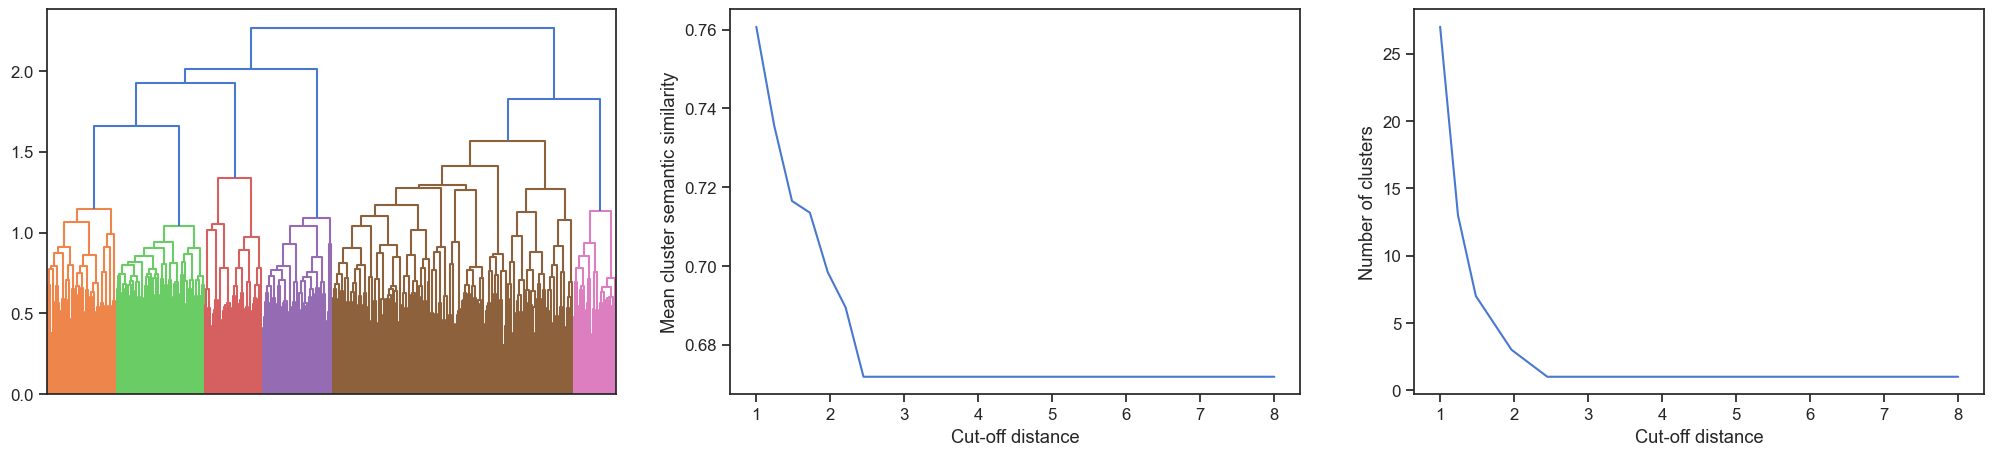

In [50]:
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
response_to_cluster_vf, cluster_to_response_vf, num_clusters_vf, minsim_vf = perform_hierarchicalClustering([sentence_transformer_embeddings_vf[x] for x in texts_vf], texts_vf, ax, 1.14, printclusters)
print("Num clusters =", num_clusters_vf)
print(np.min(list(minsim_vf.values())), np.mean(list(minsim_vf.values())))

## Write Category, Semantic Similarity, Jump

#### Jump Procedure
<img src="../figures/jump_procedure.png" width="200">

In [51]:
def write_category_SS_jump_filterorder0(data):
    # write category using response_to_cluster
    data.loc[data["task"] == 2, "category"] = data[data["task"] == 2]["response"].apply(lambda x: response_to_cluster_autbrick.get(x))
    data.loc[data["task"] == 3, "category"] = data[data["task"] == 3]["response"].apply(lambda x: response_to_cluster_autpaperclip.get(x))
    data.loc[data["task"] == 1, "category"] = data[data["task"] == 1]["response"].apply(lambda x: response_to_cluster_vf.get(x))

    # write semantic similarity using calculate_cosine_similarity
    data.loc[data["task"] == 2, 'SS'] = data[data["task"] == 2].apply(lambda row: calculate_cosine_similarity(sentence_transformer_embeddings_autbrick.get(row['response']), sentence_transformer_embeddings_autbrick.get(row['previous_response'])), axis=1)
    data.loc[data["task"] == 3, 'SS'] = data[data["task"] == 3].apply(lambda row: calculate_cosine_similarity(sentence_transformer_embeddings_autpaperclip.get(row['response']), sentence_transformer_embeddings_autpaperclip.get(row['previous_response'])), axis=1)
    data.loc[data["task"] == 1, 'SS'] = data[data["task"] == 1].apply(lambda row: calculate_cosine_similarity(sentence_transformer_embeddings_vf.get(row['response']), sentence_transformer_embeddings_vf.get(row['previous_response'])), axis=1)

    # write jump as described in Figure above
    data["category"] = data["category"].astype(int)
    data["jump_cat"] = (~(data["category"].diff() == 0)).astype(int)
    data["jump_SS"] = (data["SS"] < 0.8).astype(int)
    data['jump'] = data["jump_cat"] & data["jump_SS"]

    data = data[data["order"] > 0]      # remove the first response

    return data

data_humans = write_category_SS_jump_filterorder0(data_humans)
data_LLMs = write_category_SS_jump_filterorder0(data_LLMs)

## Evaluate Jump Goodness

In [52]:
TP = len(data_humans[(data_humans["task"] == 2) & (data_humans["jump_GT"] == 1) & (data_humans["jump"] == 1)])
TN = len(data_humans[(data_humans["task"] == 2) & (data_humans["jump_GT"] == '0') & (data_humans["jump"] == 0)])
FP = len(data_humans[(data_humans["task"] == 2) & (data_humans["jump_GT"] == '0') & (data_humans["jump"] == 1)])
FN = len(data_humans[(data_humans["task"] == 2) & (data_humans["jump_GT"] == 1) & (data_humans["jump"] == 0)])

print(TP, TN, FP, FN)

# check jump goodness - higher the better -- TPR
print("TPR =", TP/(TP + FN))

# check jump goodness - higher the better -- TNR
print("TNR =", TN/(TN + FP))

# check jump goodness - lower the better -- FPR
print("FPR =", FP/(FP + TN))

# check jump goodness - lower the better -- FNR
print("FNR =", FN/(TP + FN))

2386 197 41 636
TPR = 0.7895433487756452
TNR = 0.8277310924369747
FPR = 0.1722689075630252
FNR = 0.21045665122435472


## Write Originality

In [53]:
autbrick_scored = pd.read_csv("../csvs/autbrick_scored.csv")
autpaperclip_scored = pd.read_csv("../csvs/autpaperclip_scored.csv")
data_humans.loc[data_humans["task"] == 2, "originality"] = data_humans["response"].map(autbrick_scored.set_index('response')['originality'].to_dict())
data_humans.loc[data_humans["task"] == 3, "originality"] = data_humans["response"].map(autpaperclip_scored.set_index('response')['originality'].to_dict())
data_LLMs.loc[data_LLMs["task"] == 2, "originality"] = data_LLMs["response"].map(autbrick_scored.set_index('response')['originality'].to_dict())
data_LLMs.loc[data_LLMs["task"] == 3, "originality"] = data_LLMs["response"].map(autpaperclip_scored.set_index('response')['originality'].to_dict())

## Get Jump Profiles

In [54]:
# If jumps are [1,0,1], jump profile is [1,1,2] 
data_humans["jump_profile"] = data_humans.groupby(["pid", "task"])["jump"].cumsum()
data_LLMs["jump_profile"] = data_LLMs.groupby(["task", "pid"])["jump"].cumsum()

## View csvs

In [55]:
data_humans

,pid,task,starttime,endtime,original_response_Dutch,original_response,original_response_cleaned,response,invalid,jump_GT,...,previous_response,order,RT,category,SS,jump_cat,jump_SS,jump,originality,jump_profile
1,2657,1,1612269656493,1612269659361,kat,cat,cat,cat,0.0,1.0,...,dog,1,2.868,1,0.822752,1,0,0,NaN,0
2,2657,1,1612269659361,1612269662587,zeebr,seabr,seabr,zebra,0.0,1.0,...,cat,2,3.226,9,0.778502,1,1,1,NaN,1
3,2657,1,1612269662587,1612269666415,giraffe,giraffe,giraffe,giraffe,0.0,1.0,...,zebra,3,3.828,14,0.819355,1,0,0,NaN,1
4,2657,1,1612269666415,1612269671971,zeehond,seal,seal,seal,0.0,1.0,...,giraffe,4,5.556,13,0.766122,1,1,1,NaN,2
5,2657,1,1612269671971,1612269677895,leeuw,lion,lion,lion,0.0,1.0,...,seal,5,5.924,1,0.811158,1,0,0,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15394,2972,3,1615397164278,1615397198463,om stof bij elkaar te houden als iemand kleding maakt,to hold fabric together when someone makes clothes,hold fabric together makes clothes,hold fabric together,0.0,1.0,...,prevent zip from opening,15,34.185,20,0.788151,1,1,1,1.0,13
15395,2972,3,1615397198463,1615397229212,om een zakje snoep of chips dicht te kunnen houden,to keep a bag of candy or chips closed,keep bag candy chips closed,close chips,0.0,1.0,...,hold fabric together,16,30.749,6,0.759105,1,1,1,2.0,14
15396,2972,3,1615397229212,1615397292049,Om de stelen van je planten aan elkaar vast te maken,To connect the stems of your plants together,connect stems plants together,connect stems plants together,0.0,1.0,...,close chips,17,62.837,9,0.778677,1,1,1,3.0,15
15397,2972,3,1615397292049,1615397340284,om je fitness matje die opgerold is aan de zijkanten vast te maken,to attach your fitness mat that is rolled up on the sides,attach fitness mat rolled sides,attach fitness mats,0.0,1.0,...,connect stems plants together,18,48.235,8,0.783338,1,1,1,3.0,16


In [56]:
data_LLMs

,task,model,temp,rep,original_response,pid,original_response_cleaned,response,invalid,jump_GT,...,previous_original_response,previous_response,order,category,SS,jump_cat,jump_SS,jump,originality,jump_profile
1,1,mistralai/Mistral-7B-Instruct-v0.2,0.0,1,giraffe,1,giraffe,giraffe,NaN,NaN,...,elephant,elephant,1,14,0.850128,1,0,0,NaN,0
2,1,mistralai/Mistral-7B-Instruct-v0.2,0.0,1,zebra,1,zebra,zebra,NaN,NaN,...,giraffe,giraffe,2,9,0.819355,1,0,0,NaN,0
3,1,mistralai/Mistral-7B-Instruct-v0.2,0.0,1,rhinoceros,1,rhinoceros,rhinoceros,NaN,NaN,...,zebra,zebra,3,9,0.827097,0,0,0,NaN,0
4,1,mistralai/Mistral-7B-Instruct-v0.2,0.0,1,hippopotamus,1,hippopotamus,hippopotamus,NaN,NaN,...,rhinoceros,rhinoceros,4,9,0.844673,0,0,0,NaN,0
5,1,mistralai/Mistral-7B-Instruct-v0.2,0.0,1,kangaroo,1,kangaroo,kangaroo,NaN,NaN,...,hippopotamus,hippopotamus,5,5,0.819636,1,0,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33801,3,meta-llama/Llama-3-70b-chat-hf,1.0,5,embossing tool,495,embossing tool,embossing tool,NaN,NaN,...,plant marker,plant marker,15,13,0.777784,1,1,1,3.0,11
33802,3,meta-llama/Llama-3-70b-chat-hf,1.0,5,wire stripper,495,wire stripper,wire stripper,NaN,NaN,...,embossing tool,embossing tool,16,26,0.779906,1,1,1,2.5,12
33803,3,meta-llama/Llama-3-70b-chat-hf,1.0,5,rivet setter,495,rivet setter,rivet setter,NaN,NaN,...,wire stripper,wire stripper,17,14,0.812741,1,0,0,3.0,12
33804,3,meta-llama/Llama-3-70b-chat-hf,1.0,5,fastener,495,fastener,fastener,NaN,NaN,...,rivet setter,rivet setter,18,20,0.833713,1,0,0,1.0,12


## Write csvs

In [58]:
# Uncommenting next 2 lines will overwrite the exisiting csvs
# data_humans.to_csv("../csvs/data_humans.csv")
# data_LLMs.to_csv("../csvs/data_LLMs.csv")